# Part 1: Intro
## Project Description
The airline industry is currently the biggest transportation industry in the world. It focuses on service strategy to get customers, because an excellent quality of service is a way to get customer loyalty. Understanding customer needs, requests, and feedback is crucial for improving business and providing best customer service. Airline companies are interested in analyzing customers’ review data to achieve customer satisfaction to get repeat business.
## Objective:
The task is to do sentiment analysis about the problems of each major U.S. airline.

## Data Information
This dataset is from https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment Total number of data: 14641
Columns: 15 columns
The dataset contains customer reviews from twitter about airline passengers, including additional information about each tweet, time zone, location, etc.

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python Course/Tweets.csv')
#looking into our data
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#checking info our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Part 2: Exploratory Data Analysis


### 1. Total Tweet Count Per Airline

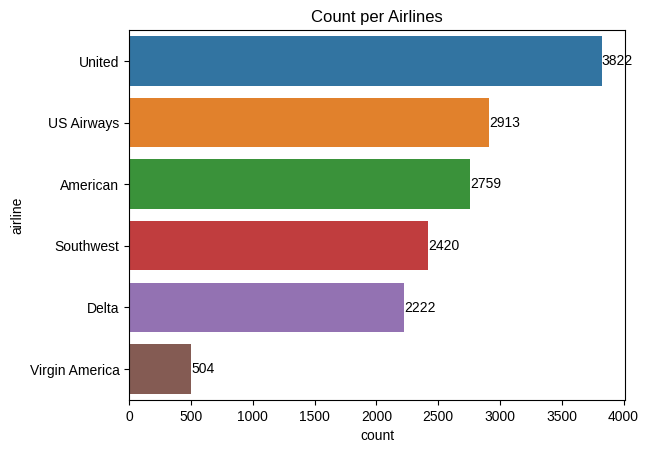

In [ ]:
plot1 = sns.countplot(data = df, y='airline', order = df.airline.value_counts().index)
plot1.bar_label(plot1.containers[0])
plot1.set_title('Count per Airlines',)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.show()

According to the dataset, United Airlines has the highest number of tweets, followed by US Airways and American Airlines. The lowest number of tweets belongs to Virgin America.

### 2. Proportion of Sentiment

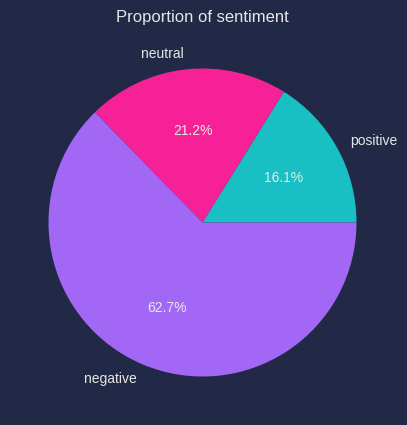

In [ ]:
x = df.airline_sentiment.value_counts().sort_values()
plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%')
plt.title('Proportion of sentiment')

plt.show()

Table of sentiment counts in each airline

In [ ]:
table_sc = df.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
table_sc

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


### 3. Proportion of Sentiment in each airlines

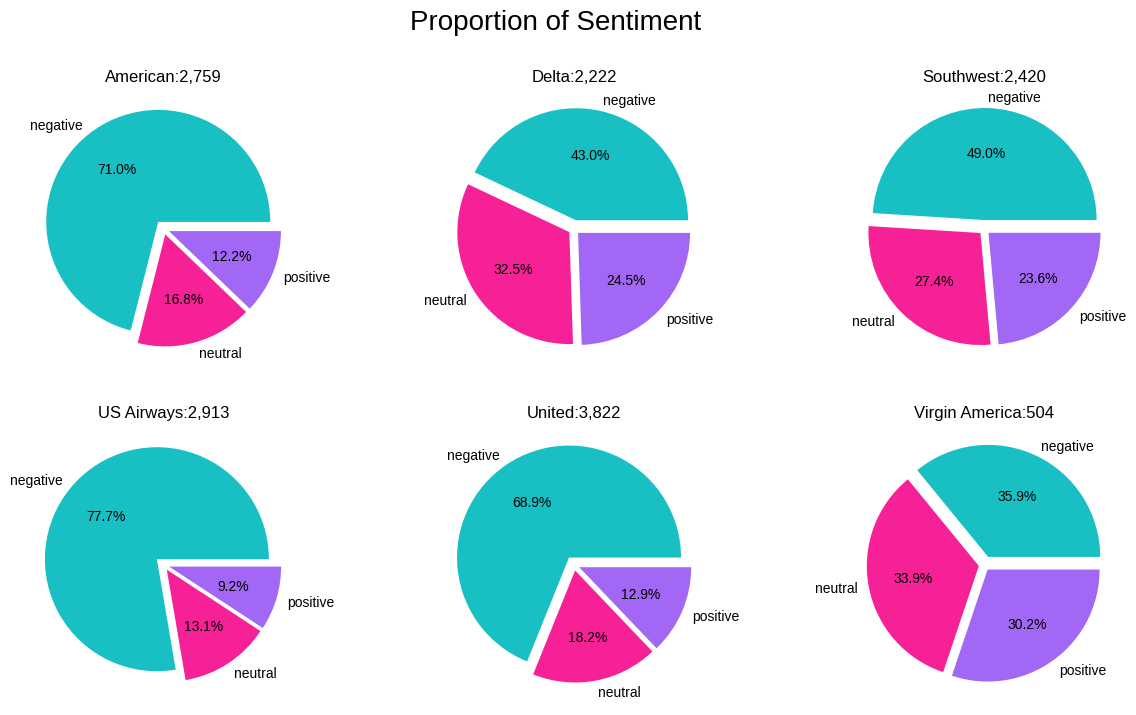

In [ ]:

fig, axes = plt.subplots(2, 3, figsize = (15, 8))
fig = plt.gcf()
fig.patch.set_facecolor('white')
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = table_sc.iloc[i]
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.05, 0.05])
    ax.set_title(f"{table_sc.index[i]}:{format(table_sc.values[i].sum(),',')}",color='black')
    plt.setp(ax.texts, color='black')


plt.suptitle("Proportion of Sentiment", fontsize = 20, color='black')
plt.show()

Findings:
* The negative sentiment ratios for both "American Airlines" and "US Airways Airlines" exceed 70%. Interestingly, the two airlines merged in 2015.

* The proportion of negative tweets about United Airlines was close to 70%.

* The negative sentiment ratios for Southwest and Delta Airlines are below 50%.

* Virgin America's sentiment ratios are well-balanced, but this could be because they have fewer tweets overall.


### 4. Reasons Of Negative Tweets

In [ ]:
# Show negative resons type
print(df.negativereason.unique())

[nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


In [ ]:
# Pick only sentiment = "negative"
df_neg = df[df.airline_sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9178, 15)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
15,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada)
17,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada)


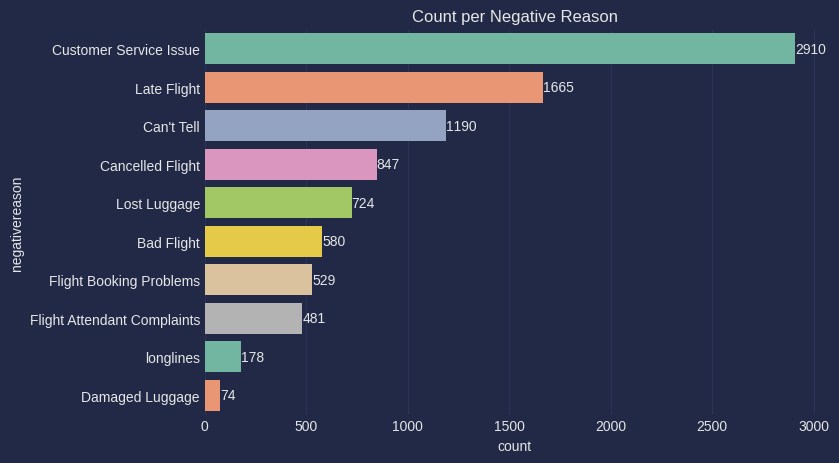

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per Negative Reason')

plt.show()

According to the findings, the TOP3 negative reasons reported were "Customer Service Issue," "Late Flight," and "Can't Tell." Customer Service Issue had the highest ratio of over 30% among all the negative reasons, indicating that it was the main issue.

### 5. Proportion of Negative Reason in each airlines

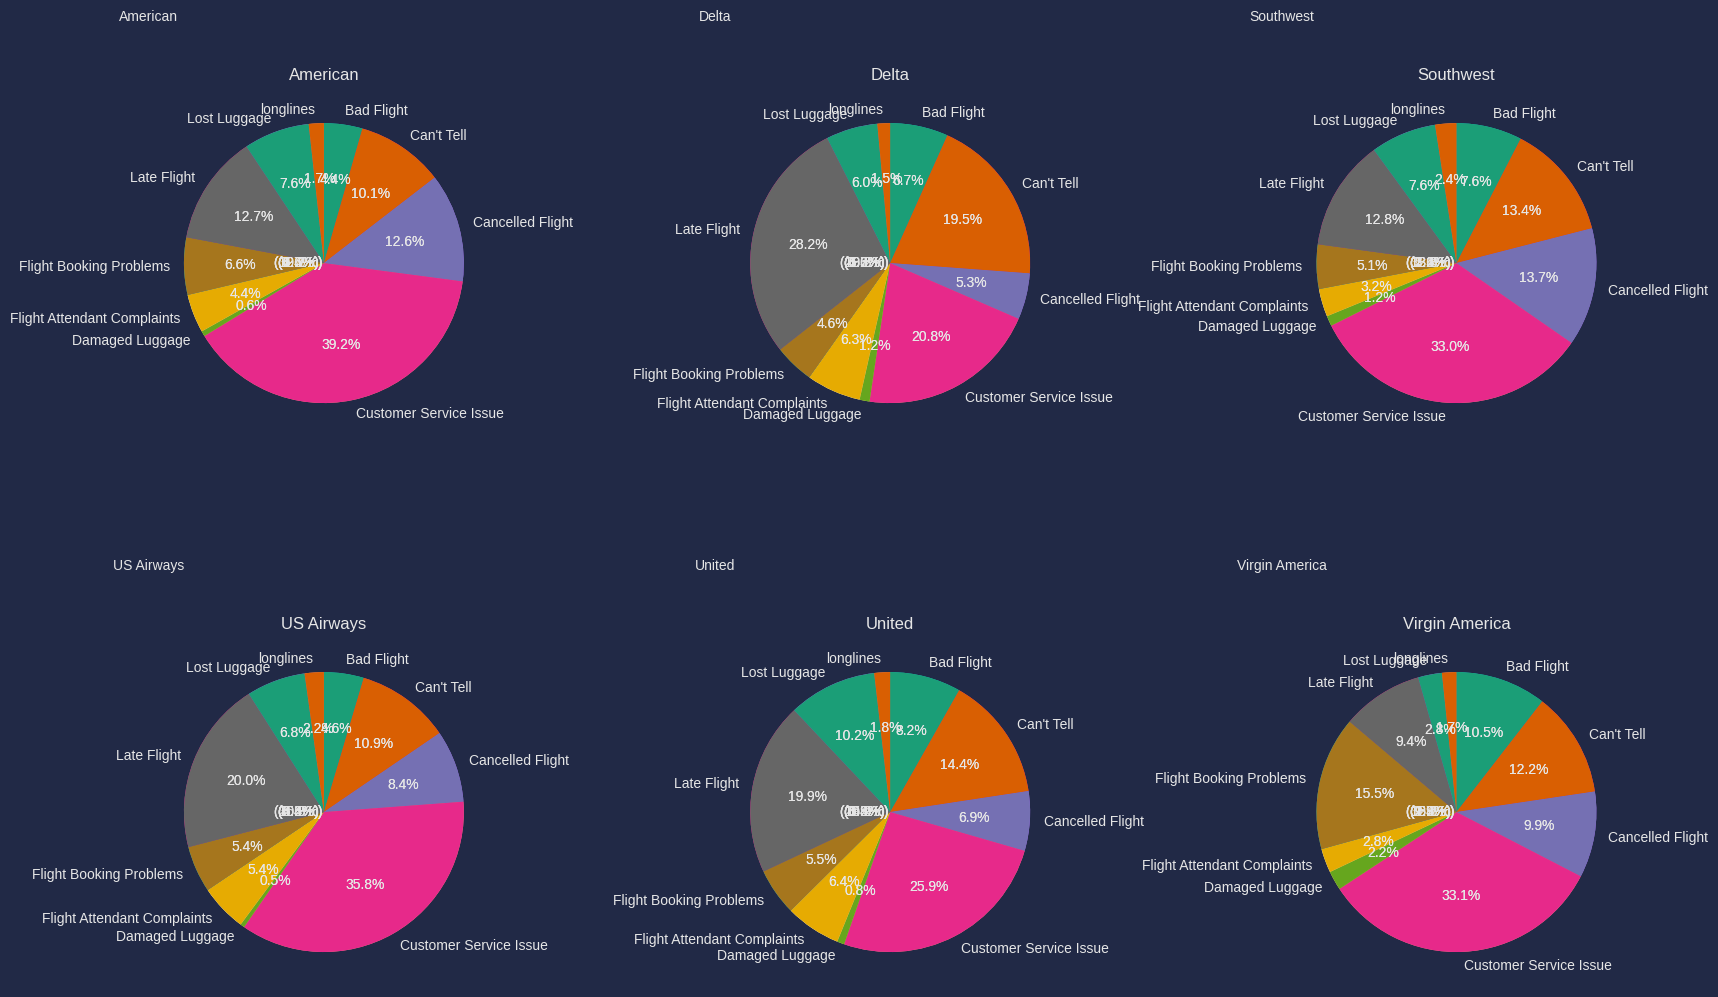

In [ ]:
import matplotlib.pyplot as plt

# Compute the proportions of negative reasons for each airline
negative_reasons = df_neg.groupby('airline')['negativereason'].value_counts(normalize=True)

# Reshape the data to have the airlines as rows and negative reasons as columns
negative_reasons = negative_reasons.unstack(level=-1)

# Plot the pie charts for each airline
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
for i, (airline, ax) in enumerate(zip(negative_reasons.index, axes.flatten())):
    negative_reasons.loc[airline].plot(kind='pie', ax=ax, legend=False, autopct='%1.1f%%', startangle=90, counterclock=False)
    ax.set_title(airline)
    ax.set_ylabel('')
    ax.text(0, 1.1, f'{airline}\n\n', transform=ax.transAxes, ha='center')

    # Add text labels for the proportions
    wedges, labels, _ = ax.pie(negative_reasons.loc[airline], colors=plt.cm.Dark2.colors, autopct='%1.1f%%', startangle=90, counterclock=False)
    for wedge, label in zip(wedges, labels):
        fraction = (wedge.theta2 - wedge.theta1) / 360
        x, y = wedge.center
        ax.annotate(f'{label.get_text()} ({fraction*100:.1f}%)', xy=(x, y), xytext=(-20,0), textcoords='offset points', ha='center', va='center', fontsize=10)


# Set the layout to be flat with 3 airlines in each row
fig.tight_layout(pad=4, w_pad=0.5, h_pad=1)


In [ ]:
# Compute the proportions of negative reasons for each airline
negative_reasons = df_neg.groupby('airline')['negativereason'].value_counts(normalize=True)

# Reshape the data to have the airlines as rows and negative reasons as columns
negative_reasons = negative_reasons.unstack(level=-1)

# Compute the total proportion of negative reasons for each airline
total_props = negative_reasons.sum(axis=1)

# Compute the proportion of each negative reason for each airline
airline_props = (negative_reasons.div(total_props, axis=0) * 100).round(2)

# Sort the negative reasons in descending order for each airline
airline_props = airline_props.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Print the table of proportions for each airline
for airline in airline_props.index:
    print(f'Proportions of negative reasons for {airline}:')
    print(airline_props.loc[airline])
    print()

Proportions of negative reasons for American:
negativereason
Bad Flight                      4.44
Can't Tell                     10.10
Cancelled Flight               12.55
Customer Service Issue         39.18
Damaged Luggage                 0.61
Flight Attendant Complaints     4.44
Flight Booking Problems         6.63
Late Flight                    12.70
Lost Luggage                    7.60
longlines                       1.73
Name: American, dtype: float64

Proportions of negative reasons for Delta:
negativereason
Bad Flight                      6.70
Can't Tell                     19.48
Cancelled Flight                5.34
Customer Service Issue         20.84
Damaged Luggage                 1.15
Flight Attendant Complaints     6.28
Flight Booking Problems         4.61
Late Flight                    28.17
Lost Luggage                    5.97
longlines                       1.47
Name: Delta, dtype: float64

Proportions of negative reasons for Southwest:
negativereason
Bad Flight        

####  Proportions of negative reasons in each airlines
1. American:
* Customer service issues are  ccounting for almost 40% of all negative reasons reported which is the highest amongs each airline

2. Delta:

* Late flights are the biggest negative reason for Delta, accounting for almost 30% of all negative reasons reported by passengers.

3. Southwest:

* common negative reasons include cancelled flight (13.66%) and can't tell (13.41%).
4. US Airways:

* Late flights are the second biggest negative reason, accounting for about 20% of all negative reasons and followeb by it is can't tell (10.87%)
5. United:

* Similar to Delta, late flights are the  biggest negative reason for United, accounting for almost 20% of all negative reasons reported by passengers.

6. Virgin America:

* Only Virgin America has high Flight booking problems proportion, accounting for about 15.5% of all negative reasons.

## 6. Word Cloud about sentiment before text processing

In [ ]:
from wordcloud import WordCloud

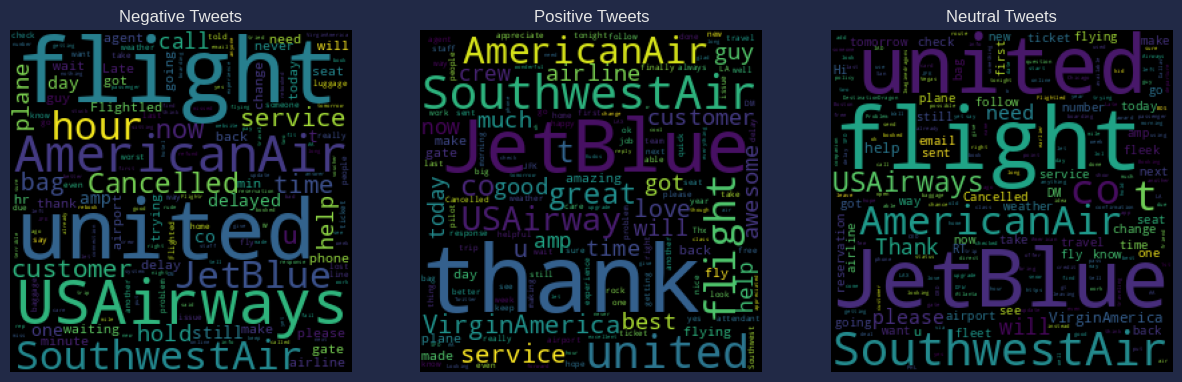

In [ ]:
negative = " ".join(df[df['airline_sentiment'] == 'negative']['text'].to_list())
positive = " ".join(df[df['airline_sentiment'] == 'positive']['text'].to_list())
neutral = " ".join(df[df['airline_sentiment'] == 'neutral']['text'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ng_wlc = WordCloud(width=256, height=256, collocations=False).generate(negative)
ps_wlc = WordCloud(width=256, height=256, collocations=False).generate(positive)
ne_wlc = WordCloud(width=256, height=256, collocations=False).generate(neutral)
wcs = [ng_wlc, ps_wlc, ne_wlc]
titls = ["Negative Tweets", "Positive Tweets", "Neutral Tweets"]

for num, el in enumerate(wcs):
    ax[num].imshow(el)
    ax[num].axis('off')
    ax[num].set_title(titls[num])

* Based on the Negative Tweets word cloud, we can observe that USAirways, United, AmericanAir, and SouthwestAir are the airlines that appear most frequently. The appearance of words such as "Cancelled," "bag," and "Customer service" may suggest that passengers were dissatisfied with these aspects of these airlines.

* In the Positive tweets word cloud, JetBlue stands out as the second most frequently mentioned airline. However, it's important to note that we do not have JetBlue's airline records in our dataset.

* Looking at the Neutral tweets, we can see that JetBlue, Southwest, United, and AmericanAir account for a significant portion, even though they also appear in the Negative Tweets word cloud. This may suggest that passengers did not have a strong positive or negative sentiment towards these airlines.



### 7. Text length


<ipython-input-16-c2f1d545dce4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.text.str.len())


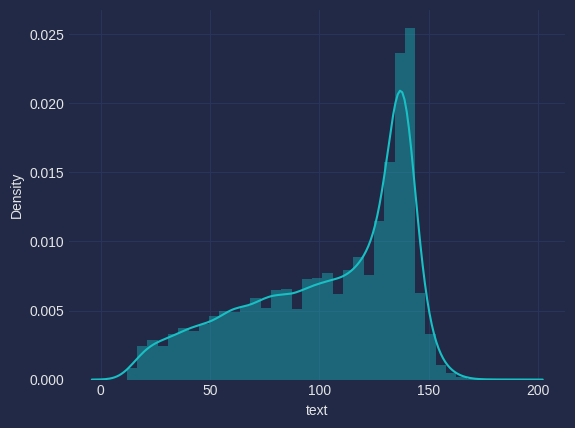

In [ ]:
sns.distplot(df.text.str.len())

plt.show()

In [ ]:
df.text.str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

* The average length of a tweet in the dataset is 103.8 characters, with a standard deviation of 36.3 characters.
* The shortest tweet in the dataset is 12 characters long, while the longest tweet is 186 characters long.

# Part 3: Text Preprocessing

In [ ]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

def tokenizer(description):
    description = description.lower()
    description = re.sub('[^a-zA-Z0-9]', ' ', description)
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    words = tokenizer.tokenize(description)
    tokenized_words = ' '.join(words)
    return tokenized_words

def remove_stopwords(words):
    tokens = words.split(' ')
    stop = set(stopwords.words('english'))
    filtered_words = ' '.join([w for w in tokens if not w in stop])
    return filtered_words

def get_part_of_speech_tags(token):

    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    tag = nltk.pos_tag([token])[0][1][0].upper()

    return tag_dict.get(tag, wordnet.NOUN)

def postag_lemmentization(words):
    token_list = words.split(' ')
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = ' '.join([lemmatizer.lemmatize(token, get_part_of_speech_tags(token)) for token in token_list])
    return lemmatized_words

In [ ]:
df['text'] = df['text'].apply(tokenizer)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(postag_lemmentization)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,virginamerica dhepburn say,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica plus add commercial experience t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,virginamerica today must mean need take anothe...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,virginamerica really aggressive blast obnoxiou...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,virginamerica really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Part 4: Text Analysis (Vectorization)

In [ ]:
#Separate columns with reviews and sentiment labels
X = df.iloc[:,-5] # extract column with review
y = df.iloc[:,1] # extract column with sentiment

In [ ]:
#Use CountVectorizer to preprocess data
import numpy as np
# tokenize the review text and convert data in matrix format
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(X)
X_vec

<14640x12860 sparse matrix of type '<class 'numpy.int64'>'
	with 126811 stored elements in Compressed Sparse Row format>

# Sentiment Models Building (Naive bayes)

In [ ]:
#Build TF-IDF representation from the review text and split the training and testing set by 80%/20%.

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)
X_tfidf = X_tfidf.todense()
X_tfidf = np.asarray(X_tfidf)
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y,
                                                    test_size = 0.2, random_state = 0)

In [ ]:
# Train the NB classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predicting the Test set results
y_pred = clf.predict(X_test)

# Model Evaluation (Naive bayes)

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Modify the color map (cmap) of the underlying Matplotlib figure
disp.figure_.color_map.set_cmap('Blues')  # Change the color map to 'Blues'

disp.plot()
plt.show()


AttributeError: ignored

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, cmap='Blues')  # Change the color map to 'Blues'
disp.plot()


TypeError: ignored

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, cmap='Blues')
disp.plot()

TypeError: ignored

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, cmap='Blues')  # Change the color map to 'Blues'
disp.plot()


TypeError: ignored

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

    negative       0.69      0.99      0.81      1870
     neutral       0.72      0.16      0.26       614
    positive       0.86      0.16      0.28       444

    accuracy                           0.69      2928
   macro avg       0.75      0.44      0.45      2928
weighted avg       0.72      0.69      0.61      2928



# SVM Model and Evaluation

In [ ]:
# Fitting SVM to training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred)
print(cr)